# Getting started with TinyTimeMixer (TTM) with Exogenous Infusion 

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks with exogenous infusion. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune*: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the future values mentioned in `control_columns` as exogenous features for modelling. Search for `# exog:` keyword for important parameters to edit for exogenous infusion.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

## Installation

In [12]:
# Install the tsfm library
! git clone https://github.com/ibm-granite/granite-tsfm.git
!ls

# Change directory. Move inside the tsfm repo.
%cd granite-tsfm
! ls

# Install the tsfm library
! pip install ".[notebooks]"

fatal: destination path 'granite-tsfm' already exists and is not an empty directory.
README.md	    ttm_finetuned_models
datasets	    ttm_venice_levels.ipynb
granite-tsfm	    ttm_venice_levels_watsonx.ipynb
images		    ttm_with_exog_tutorial.ipynb
install_tsfm.ipynb  ttm_with_exog_tutorial.ipynb:Zone.Identifier
/home/proz/Progetti/ttm_new/TTM/granite-tsfm
LICENSE    UNKNOWN.egg-info  pyproject.toml	  services     tsfmhfdemos
Makefile   build	     pyproject.toml.orig  tests        wiki.md
README.md  notebooks	     scripts		  tsfm_public


/home/proz/Progetti/ttm_new/ttm-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Processing /home/proz/Progetti/ttm_new/TTM/granite-tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 496.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 862.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 281.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 368.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 337.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 130.7 kB/s eta 0:00:00a 0:00:01
  Using cached setuptools-75.6.0-py3-none-any.whl.metadata (6.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [13]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

INFO:p-4514:t-140190869663872:font_manager.py:_load_fontmanager:generated new fontManager


## Important arguments

In [21]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "venice"
DATA_ROOT_PATH = "/datasets/venice_small.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# Forecasting parameters
context_length = 1024
forecast_length = 96

## Data processing pipeline

In [18]:
# Load the data file and see the columns

timestamp_column = "DATE"
# timestamp_column = "timestamp"
id_columns = []


data = pd.read_csv(
    DATA_ROOT_PATH,
    parse_dates=[timestamp_column],
)

"""
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Reset the index to ensure the hours are correctly assigned, as hour information is missing in the original timestamp of this df
data[timestamp_column] = data[timestamp_column] + pd.to_timedelta(
    data.groupby(data[timestamp_column].dt.date).cumcount(), unit="h"
)
"""

print(data)
# data = pd.read_csv(
#     "/dccstor/tsfm23/datasets/exogs_expts/bike_sharing_dataset/processed_data/bike_sharing_hourly_processed.csv",
#     # parse_dates=[timestamp_column],
# )

# print(data)

# exog: Mention Exog channels in control_columns and target in target_columns

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": ["LEVEL"],
    "control_columns": [
        "PRESS",
        "RAIN",
        "TEMP",
        "WDIR",
        "WSPEED"
    ],
}

split_params = {"train": [0, 0.5], "valid": [0.5, 0.75], "test": [0.75, 1.0]}

       Unnamed: 0                DATE  LEVEL   PRESS  RAIN  TEMP   WDIR  \
0               0 2020-01-01 00:00:00   28.0  1030.8   0.0   6.6  308.0   
1               1 2020-01-01 01:00:00   37.0  1031.3   0.0   7.0  341.0   
2               2 2020-01-01 02:00:00   42.0  1031.2   0.0   6.8  343.0   
3               3 2020-01-01 03:00:00   44.0  1031.1   0.0   6.9  326.0   
4               4 2020-01-01 04:00:00   43.0  1031.1   0.0   6.9  346.0   
...           ...                 ...    ...     ...   ...   ...    ...   
15273       15273 2021-09-28 09:00:00    NaN  1019.6   0.0  18.8  310.0   
15274       15274 2021-09-28 10:00:00    NaN  1019.7   0.0  20.6  328.0   
15275       15275 2021-09-28 11:00:00    NaN  1019.6   0.0  20.5  307.0   
15276       15276 2021-09-28 12:00:00    NaN  1019.5   0.0  21.3  270.0   
15277       15277 2021-09-28 13:00:00    NaN  1019.1   0.0  22.6  252.0   

       WSPEED  
0         3.2  
1         3.9  
2         2.8  
3         2.4  
4         4.1  
...

In [33]:
# Load the data file and see the columns

timestamp_column = "DATE"
# timestamp_column = "timestamp"
id_columns = []


data = pd.read_csv(
    DATA_ROOT_PATH,
    parse_dates=[timestamp_column],
)

"""
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Reset the index to ensure the hours are correctly assigned, as hour information is missing in the original timestamp of this df
data[timestamp_column] = data[timestamp_column] + pd.to_timedelta(
    data.groupby(data[timestamp_column].dt.date).cumcount(), unit="h"
)
"""

print(data)
# data = pd.read_csv(
#     "/dccstor/tsfm23/datasets/exogs_expts/bike_sharing_dataset/processed_data/bike_sharing_hourly_processed.csv",
#     # parse_dates=[timestamp_column],
# )

# print(data)

# exog: Mention Exog channels in control_columns and target in target_columns

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": ["LEVEL",
        "PRESS",
        "RAIN",
        "TEMP",
        "WDIR",
        "WSPEED"],
    "control_columns": [],
}

split_params = {"train": [0, 0.5], "valid": [0.5, 0.75], "test": [0.75, 1.0]}

       Unnamed: 0                DATE  LEVEL   PRESS  RAIN  TEMP   WDIR  \
0               0 2020-01-01 00:00:00   28.0  1030.8   0.0   6.6  308.0   
1               1 2020-01-01 01:00:00   37.0  1031.3   0.0   7.0  341.0   
2               2 2020-01-01 02:00:00   42.0  1031.2   0.0   6.8  343.0   
3               3 2020-01-01 03:00:00   44.0  1031.1   0.0   6.9  326.0   
4               4 2020-01-01 04:00:00   43.0  1031.1   0.0   6.9  346.0   
...           ...                 ...    ...     ...   ...   ...    ...   
15273       15273 2021-09-28 09:00:00    NaN  1019.6   0.0  18.8  310.0   
15274       15274 2021-09-28 10:00:00    NaN  1019.7   0.0  20.6  328.0   
15275       15275 2021-09-28 11:00:00    NaN  1019.6   0.0  20.5  307.0   
15276       15276 2021-09-28 12:00:00    NaN  1019.5   0.0  21.3  270.0   
15277       15277 2021-09-28 13:00:00    NaN  1019.1   0.0  22.6  252.0   

       WSPEED  
0         3.2  
1         3.9  
2         2.8  
3         2.4  
4         4.1  
...

In [34]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    data,
    split_params,
)

In [35]:
train_dataset[3]

{'past_values': tensor([[ 0.4500,  1.7846, -0.0598, -1.4340,  1.7161, -0.6739],
         [ 0.4137,  1.7846, -0.0598, -1.4340,  1.9078, -0.1531],
         [ 0.1960,  1.7971, -0.0598, -1.4778,  1.9462, -0.2757],
         ...,
         [-1.2554,  0.1096, -0.0598, -0.9374,  0.5272, -0.7964],
         [-1.8360,  0.1096, -0.0598, -0.8497,  0.4218, -0.9802],
         [-2.1626,  0.1596, -0.0598, -0.8205,  1.0641, -0.9496]]),
 'future_values': tensor([[-2.0537e+00,  2.4711e-01, -5.9792e-02, -9.8120e-01, -3.2606e-01,
          -7.6581e-01],
         [-1.4731e+00,  2.8461e-01, -5.9792e-02, -9.6660e-01, -3.6441e-01,
          -5.5137e-01],
         [-8.5629e-01,  3.3461e-01, -5.9792e-02, -1.0104e+00, -9.5964e-02,
          -5.8201e-01],
         [-5.8014e-02,  4.4711e-01, -5.9792e-02, -9.3738e-01,  1.9085e-02,
          -5.2074e-01],
         [ 6.3141e-01,  4.9711e-01, -5.9792e-02, -1.0542e+00,  2.5877e-01,
          -3.3694e-01],
         [ 1.0668e+00,  4.9711e-01, -5.9792e-02, -9.6660e-01, -1.92

## Zero-shot evaluation method

In [36]:
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)

zeroshot_model

INFO:p-4514:t-140190869663872:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-4514:t-140190869663872:get_model.py:get_model:Selected TTM `prediction_length` = 96
INFO:p-4514:t-140190869663872:get_model.py:get_model:Model loaded successfully!
INFO:p-4514:t-140190869663872:get_model.py:get_model:[TTM] context_len = 1024, forecast_len = 96


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

In [37]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

In [38]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.4612501263618469,
 'eval_model_preparation_time': 0.0019,
 'eval_runtime': 1.2482,
 'eval_samples_per_second': 2984.276,
 'eval_steps_per_second': 47.268}

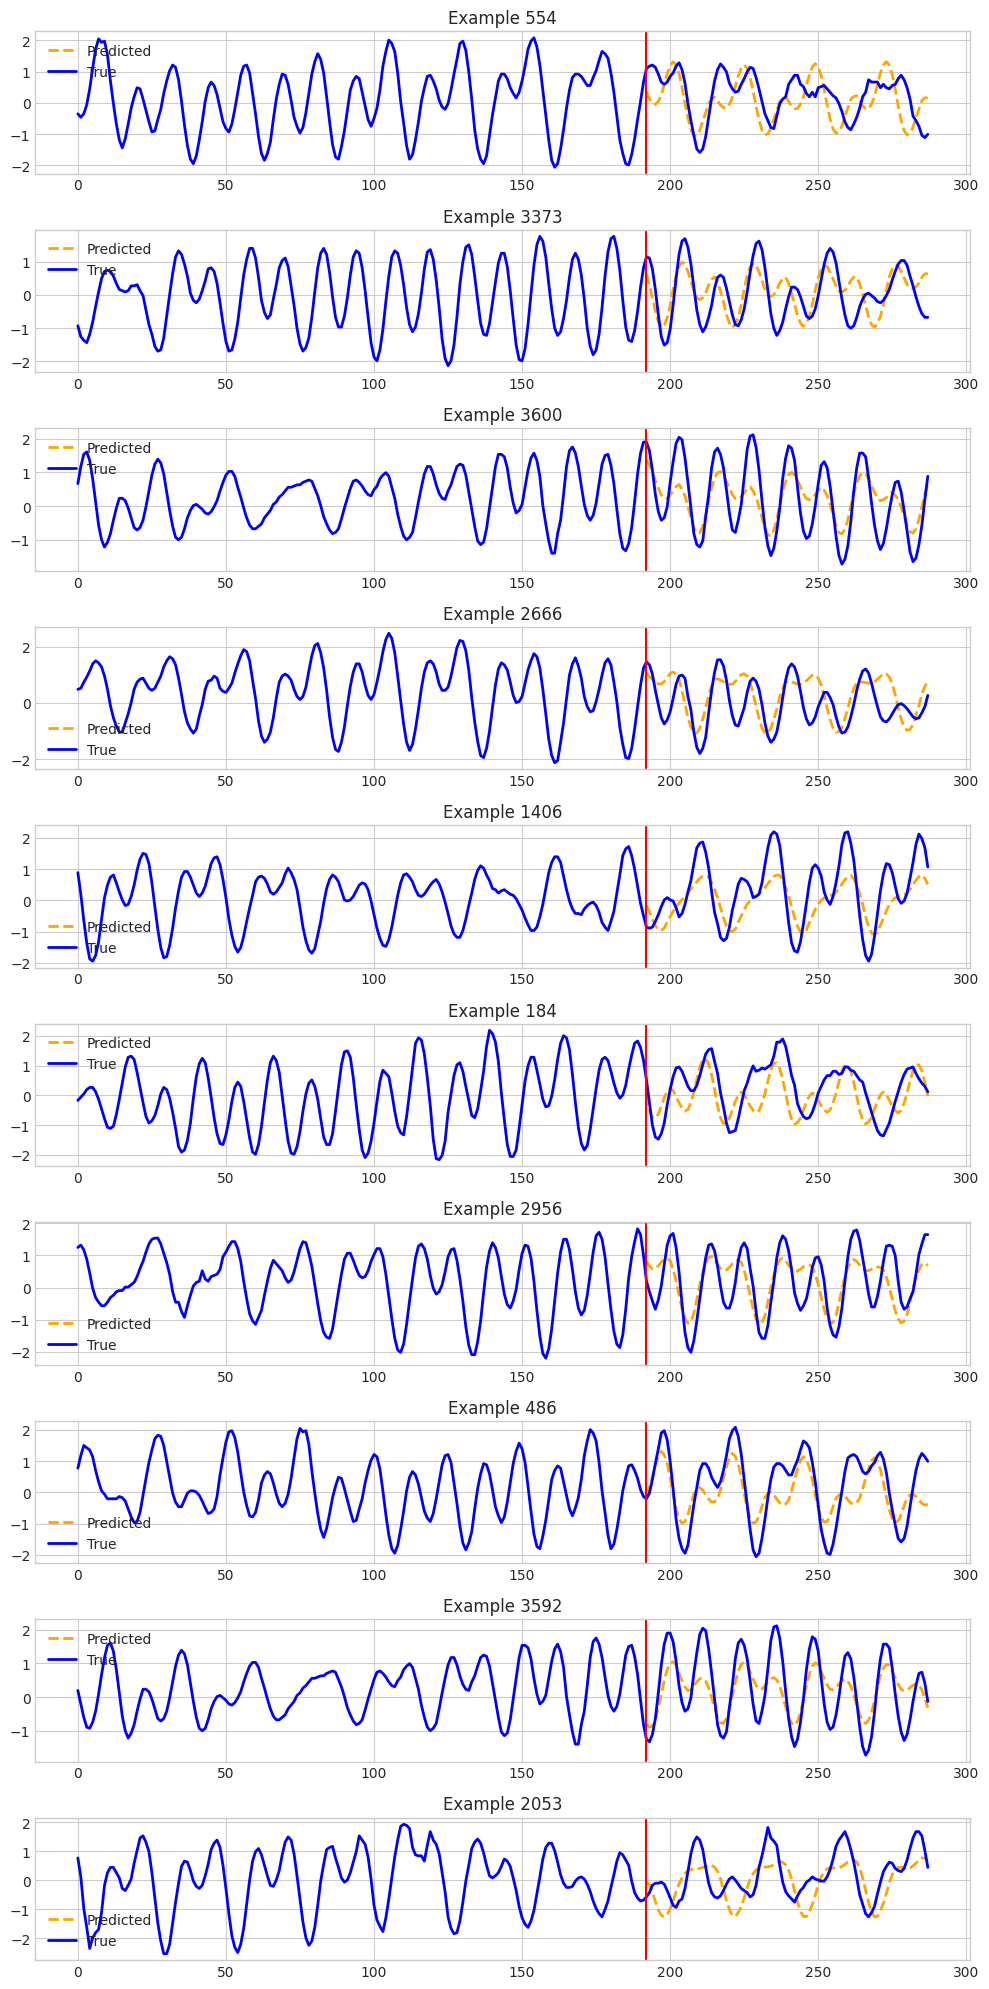

In [39]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [40]:
finetune_forecast_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)
finetune_forecast_model

INFO:p-4514:t-140190869663872:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-4514:t-140190869663872:get_model.py:get_model:Selected TTM `prediction_length` = 96
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_fea

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

### Frezze the TTM backbone

In [41]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 2968834
Number of params after freezing the backbone 959298


### Finetune model with decoder mixing and exog fusion

In [42]:
# Important parameters


# learning_rate = 0.000298364724028334
num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=False,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

INFO:p-4514:t-140190869663872:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-4514:t-140190869663872:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.
/home/proz/Progetti/ttm_new/TTM/granite-tsfm/tsfm_public/toolkit/lr_finder.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.a

OPTIMAL SUGGESTED LEARNING RATE = 0.0010974987654930567


In [43]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.0010974987654930567


/home/proz/Progetti/ttm_new/ttm-env/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.838800,0.819439
2,0.748800,0.799051
3,0.702200,0.798148
4,0.663700,0.796421
5,0.620600,0.794409
6,0.578300,0.795966
7,0.537500,0.809578
8,0.510400,0.823186
9,0.492900,0.831814
10,0.476500,0.831214


[TrackingCallback] Mean Epoch Time = 3.2798412799835206 seconds, Total Train Time = 67.09414958953857


TrainOutput(global_step=1530, training_loss=0.561204626045975, metrics={'train_runtime': 67.0951, 'train_samples_per_second': 4858.775, 'train_steps_per_second': 76.012, 'total_flos': 1.07035348451328e+16, 'train_loss': 0.561204626045975, 'epoch': 15.0})

In [44]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 0.39222452044487,
 'eval_runtime': 1.336,
 'eval_samples_per_second': 2788.122,
 'eval_steps_per_second': 44.161,
 'epoch': 15.0}

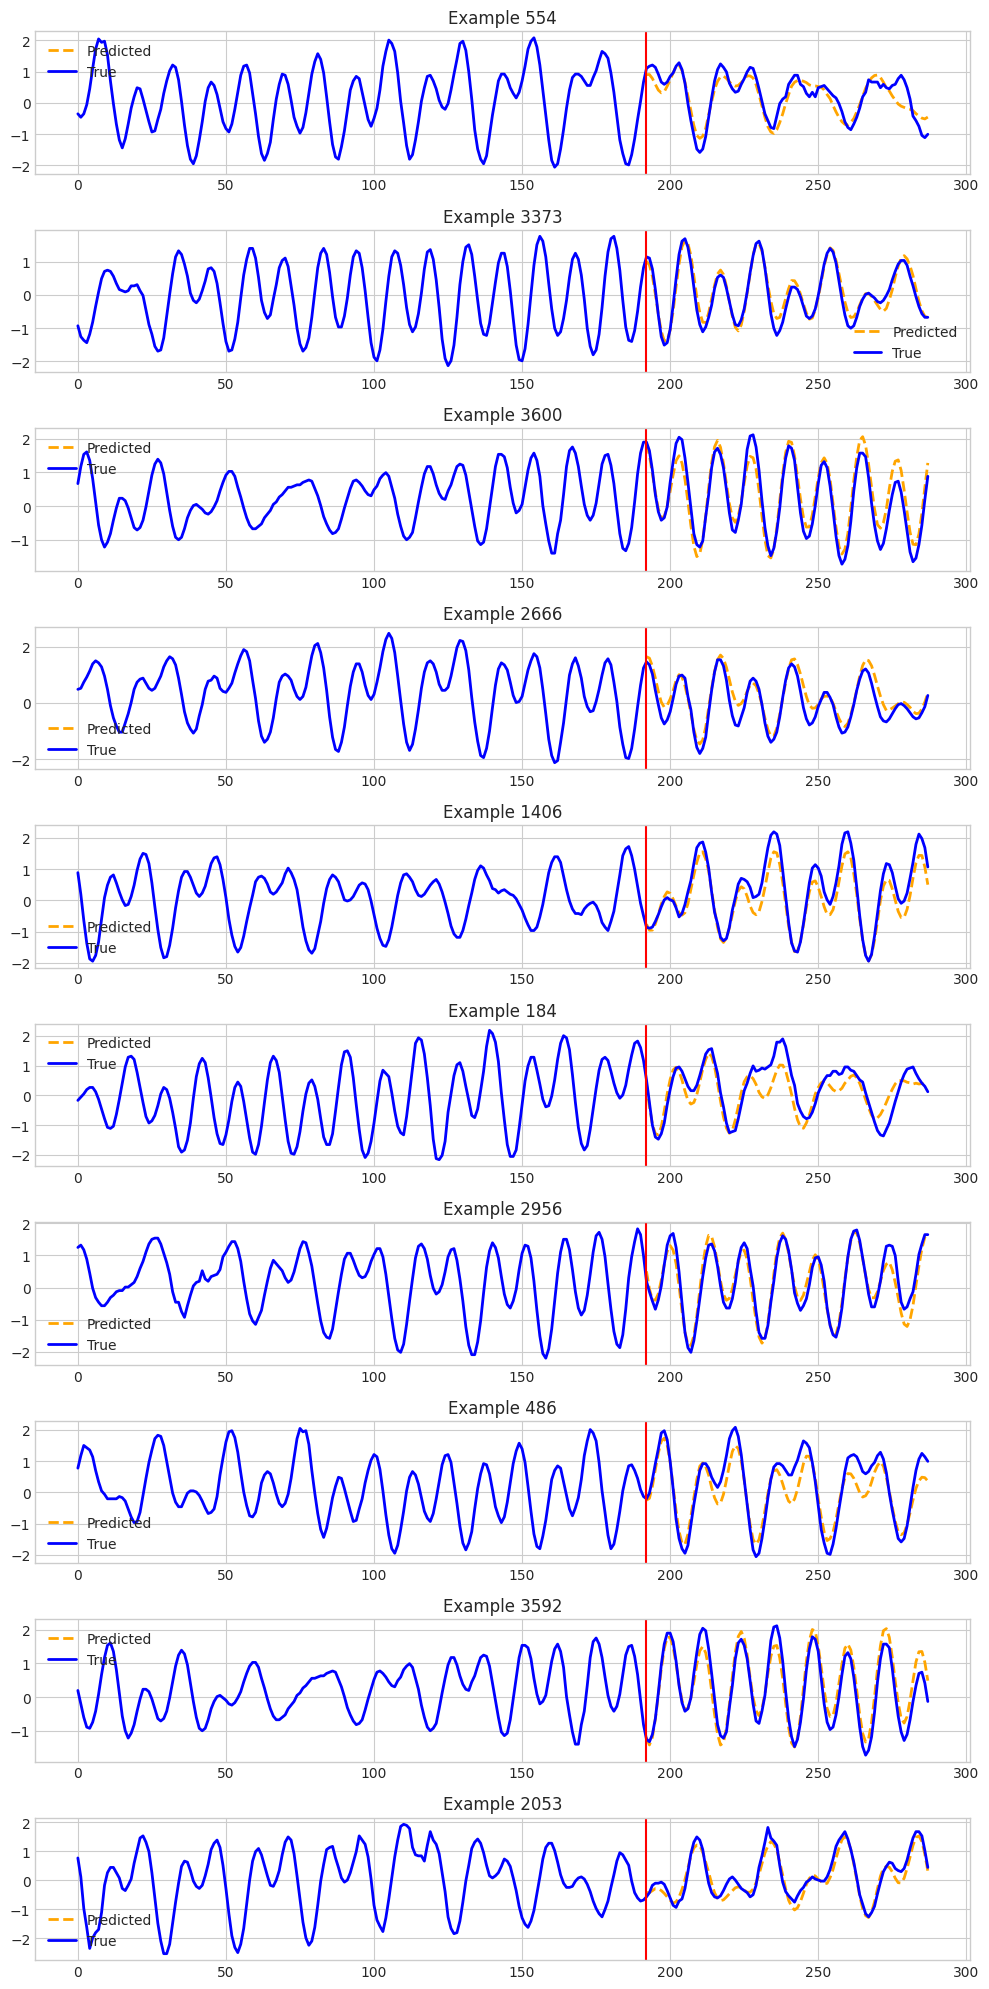

In [45]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_finetune",
    channel=0,
)